In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-may-2021/sample_submission.csv
/kaggle/input/tabular-playground-series-may-2021/train.csv
/kaggle/input/tabular-playground-series-may-2021/test.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss

In [3]:
train = pd.read_csv("/kaggle/input/tabular-playground-series-may-2021/train.csv")
test = pd.read_csv("/kaggle/input/tabular-playground-series-may-2021/test.csv")
display(train.head())
display(test.head())

,id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,target
0,0,0,0,1,0,1,0,0,0,0,...,0,0,21,0,0,0,0,0,0,Class_2
1,1,0,0,0,0,2,1,0,0,0,...,0,0,0,0,0,0,0,0,0,Class_1
2,2,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,13,2,0,Class_1
3,3,0,0,0,0,0,0,0,3,0,...,0,0,0,0,0,0,0,1,0,Class_4
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,Class_2


,id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49
0,100000,0,0,0,0,0,0,4,4,0,...,0,0,0,0,0,0,0,0,0,0
1,100001,0,0,1,0,0,0,2,0,7,...,3,0,1,0,0,0,1,0,2,1
2,100002,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,6,0
3,100003,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,6,9,14,3
4,100004,0,0,0,0,0,0,1,0,4,...,1,0,0,0,0,0,0,0,0,0


In [4]:
train.isnull().sum()

id            0
feature_0     0
feature_1     0
feature_2     0
feature_3     0
feature_4     0
feature_5     0
feature_6     0
feature_7     0
feature_8     0
feature_9     0
feature_10    0
feature_11    0
feature_12    0
feature_13    0
feature_14    0
feature_15    0
feature_16    0
feature_17    0
feature_18    0
feature_19    0
feature_20    0
feature_21    0
feature_22    0
feature_23    0
feature_24    0
feature_25    0
feature_26    0
feature_27    0
feature_28    0
feature_29    0
feature_30    0
feature_31    0
feature_32    0
feature_33    0
feature_34    0
feature_35    0
feature_36    0
feature_37    0
feature_38    0
feature_39    0
feature_40    0
feature_41    0
feature_42    0
feature_43    0
feature_44    0
feature_45    0
feature_46    0
feature_47    0
feature_48    0
feature_49    0
target        0
dtype: int64

In [5]:
test.isnull().sum()

id            0
feature_0     0
feature_1     0
feature_2     0
feature_3     0
feature_4     0
feature_5     0
feature_6     0
feature_7     0
feature_8     0
feature_9     0
feature_10    0
feature_11    0
feature_12    0
feature_13    0
feature_14    0
feature_15    0
feature_16    0
feature_17    0
feature_18    0
feature_19    0
feature_20    0
feature_21    0
feature_22    0
feature_23    0
feature_24    0
feature_25    0
feature_26    0
feature_27    0
feature_28    0
feature_29    0
feature_30    0
feature_31    0
feature_32    0
feature_33    0
feature_34    0
feature_35    0
feature_36    0
feature_37    0
feature_38    0
feature_39    0
feature_40    0
feature_41    0
feature_42    0
feature_43    0
feature_44    0
feature_45    0
feature_46    0
feature_47    0
feature_48    0
feature_49    0
dtype: int64

In [6]:
train.describe()

,id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.00000
mean,49999.500000,0.257830,0.431720,0.114130,0.590550,0.599770,0.160820,0.731490,1.228920,0.903350,...,0.712270,0.582070,0.529230,0.616310,0.135100,0.358660,0.516810,0.39004,0.970850,0.55712
std,28867.657797,0.929033,1.977862,0.519584,1.844558,2.785531,0.601149,2.343465,2.692732,3.415258,...,1.721863,2.003114,2.300826,2.360955,0.627592,1.464187,2.171415,1.48735,2.576615,1.68093
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-2.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000
25%,24999.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000
50%,49999.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000
75%,74999.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.00000
max,99999.000000,10.000000,31.000000,6.000000,26.000000,38.000000,10.000000,27.000000,31.000000,39.000000,...,21.000000,32.000000,37.000000,33.000000,9.000000,26.000000,29.000000,25.00000,44.000000,20.00000


In [7]:
cols = train.columns.tolist()
features = [col for col in cols if col not in ['target', 'id']]
features

['feature_0',
 'feature_1',
 'feature_2',
 'feature_3',
 'feature_4',
 'feature_5',
 'feature_6',
 'feature_7',
 'feature_8',
 'feature_9',
 'feature_10',
 'feature_11',
 'feature_12',
 'feature_13',
 'feature_14',
 'feature_15',
 'feature_16',
 'feature_17',
 'feature_18',
 'feature_19',
 'feature_20',
 'feature_21',
 'feature_22',
 'feature_23',
 'feature_24',
 'feature_25',
 'feature_26',
 'feature_27',
 'feature_28',
 'feature_29',
 'feature_30',
 'feature_31',
 'feature_32',
 'feature_33',
 'feature_34',
 'feature_35',
 'feature_36',
 'feature_37',
 'feature_38',
 'feature_39',
 'feature_40',
 'feature_41',
 'feature_42',
 'feature_43',
 'feature_44',
 'feature_45',
 'feature_46',
 'feature_47',
 'feature_48',
 'feature_49']

# Distribution of target w.r.t. each feature

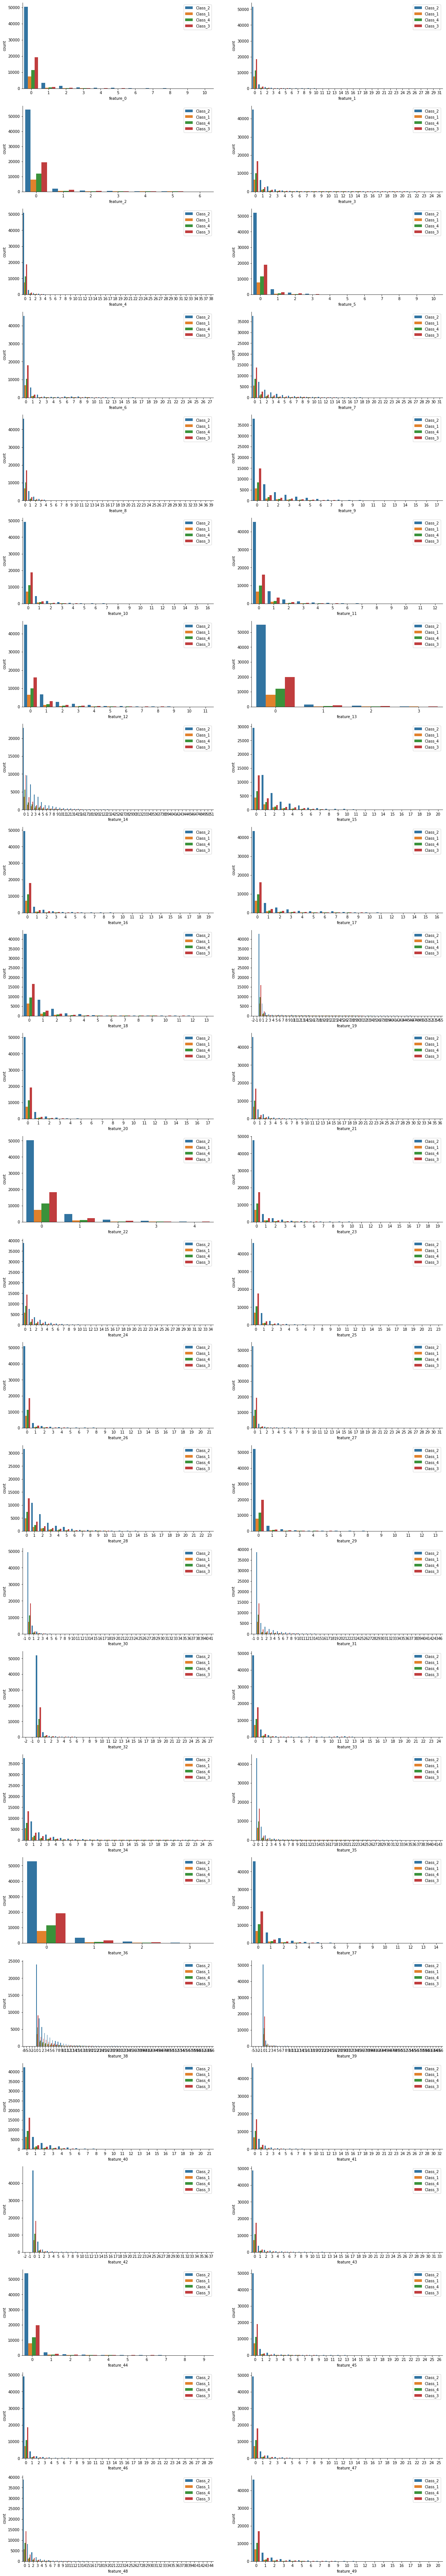

In [8]:
n_cols = 2
n_rows = len(features) // 2
size = (n_cols * 10, n_rows * 5)

plt.subplots(n_rows, n_cols, figsize=size)
sns.despine()

for i, feature in enumerate(features, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.countplot(x=feature, hue='target', data=train)
    plt.xlabel(feature)
    plt.legend(loc="upper right")
#     plt.gca().spines[['top', 'right']].set_visible(False)


In [9]:
def label_encoder(c):
    le = LabelEncoder()
    return le.fit_transform(c)

In [10]:
train.target

0        Class_2
1        Class_1
2        Class_1
3        Class_4
4        Class_2
          ...   
99995    Class_1
99996    Class_2
99997    Class_3
99998    Class_2
99999    Class_3
Name: target, Length: 100000, dtype: object

In [11]:
y = train[['target']].apply(label_encoder)


In [12]:
# y = y.target
X = train.drop(['target'], axis=1).set_index('id')
X.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49
id,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,0,1,0,0,0,0,0,...,3,0,0,21,0,0,0,0,0,0
1,0,0,0,0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,2,...,0,0,1,0,0,0,0,13,2,0
3,0,0,0,0,0,0,0,3,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [13]:
test = test.set_index('id')

In [14]:
def objective(trial, data=X, target=y):
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, random_state=0)
    
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.005, 0.02, 0.05, 0.08, 0.1]),
        'n_estimators': 4000,
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
        'gamma': trial.suggest_float('gamma', 1e-5, 1.0, log = True),
        'alpha': trial.suggest_float('alpha', 1e-5, 10.0, log = True),
        'lambda': trial.suggest_float('lambda', 1e-5, 10.0, log = True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 0.8),
        'subsample': trial.suggest_float('subsample', 0.1, 0.8),
        'tree_method': 'gpu_hist',
        'booster': 'gbtree',
        'random_state': 42,
        'use_label_encoder': False,
        'eval_metric': 'mlogloss'
    }
    
    xgb_model = XGBClassifier(**params)
    
    xgb_model.fit(X_train, y_train,
                 early_stopping_rounds = 200,
                 eval_set=[(X_val, y_val)],
                 verbose=False)
    
    preds = xgb_model.predict_proba(X_val)
    
    ll = log_loss(y_val, preds)
    return ll

In [15]:
%%time

study = optuna.create_study(direction='minimize', study_name="xgbclassifier")
study.optimize(objective, n_trials=30)

[I 2021-05-05 16:45:50,155] A new study created in memory with name: xgbclassifier
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
[I 2021-05-05 16:46:00,597] Trial 0 finished with value: 1.0955764501817524 and parameters: {'max_depth': 9, 'learning_rate': 0.08, 'min_child_weight': 100, 'gamma': 3.549577842506761e-05, 'alpha': 2.848275064865805e-05, 'lambda': 0.017911797402409994, 'colsample_bytree': 0.16839709013323115, 'subsample': 0.5814984300998162}. Best is trial 0 with value: 1.0955764501817524.
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
[I 2021-05-05 16:46:11,

CPU times: user 21min 53s, sys: 14.3 s, total: 22min 7s
Wall time: 11min 55s


In [16]:
best_params = study.best_trial.params
best_params

{'max_depth': 4,
 'learning_rate': 0.02,
 'min_child_weight': 93,
 'gamma': 0.860972908863578,
 'alpha': 0.001829533142789384,
 'lambda': 0.00450818430786801,
 'colsample_bytree': 0.1173097798351533,
 'subsample': 0.6647971603332548}

```{'max_depth': 3,
 'learning_rate': 0.02,
 'min_child_weight': 98,
 'gamma': 0.0012630885002782005,
 'alpha': 2.359102235400748,
 'lambda': 0.015246405786358556,
 'colsample_bytree': 0.6768931766402732,
 'subsample': 0.5530265845871299}```

In [17]:
optuna.visualization.plot_optimization_history(study)

In [18]:
optuna.visualization.plot_param_importances(study)

In [19]:
best_params['tree_method'] = 'gpu_hist'
best_params['booster'] = 'gbtree'
best_params['eval_metric'] = 'mlogloss'
best_params['random_state'] = 42
best_params['use_label_encoder'] = False
best_params

{'max_depth': 4,
 'learning_rate': 0.02,
 'min_child_weight': 93,
 'gamma': 0.860972908863578,
 'alpha': 0.001829533142789384,
 'lambda': 0.00450818430786801,
 'colsample_bytree': 0.1173097798351533,
 'subsample': 0.6647971603332548,
 'tree_method': 'gpu_hist',
 'booster': 'gbtree',
 'eval_metric': 'mlogloss',
 'random_state': 42,
 'use_label_encoder': False}

In [20]:
preds = np.zeros((test.shape[0], 4))
lls = []

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    
    print("Fold {}:".format(fold))
    
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    model = XGBClassifier(**best_params)
    
    model.fit(X_train, y_train,
             early_stopping_rounds=200,
             eval_set=[(X_val, y_val)],
             verbose=False)
    ll = log_loss(y_val, model.predict_proba(X_val))
    print("LogLoss: {}".format(ll))
    lls.append(ll)
    
    preds += model.predict_proba(test)
    
preds /= skf.n_splits

Fold 0:


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



LogLoss: 1.1281799662590026
Fold 1:
LogLoss: 1.1285865633904935


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



Fold 2:
LogLoss: 1.1277233931422233


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



Fold 3:
LogLoss: 1.1282909150242806


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



Fold 4:
LogLoss: 1.1283663717985153


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



Fold 5:
LogLoss: 1.1277072697341441


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



Fold 6:
LogLoss: 1.1280822301506996


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



Fold 7:
LogLoss: 1.1279719903588294


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



Fold 8:
LogLoss: 1.1279534070074557


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



Fold 9:
LogLoss: 1.128090257203579


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



In [21]:
submission = pd.DataFrame(preds)
submission.columns = ['Class_1', 'Class_2', 'Class_3', 'Class_4']
submission['id'] = test.index
submission = submission[['id', 'Class_1', 'Class_2', 'Class_3', 'Class_4']]

submission.to_csv("sub_1.csv", index=False)
display(submission.head(), submission.tail())

,id,Class_1,Class_2,Class_3,Class_4
0,100000,0.126591,0.508643,0.211367,0.153399
1,100001,0.126404,0.510858,0.213122,0.149616
2,100002,0.127982,0.511047,0.212400,0.148571
3,100003,0.127696,0.503381,0.220567,0.148356
4,100004,0.125391,0.509408,0.212115,0.153085


,id,Class_1,Class_2,Class_3,Class_4
49995,149995,0.125461,0.523105,0.209665,0.141769
49996,149996,0.126464,0.514577,0.202793,0.156166
49997,149997,0.127972,0.495938,0.218054,0.158036
49998,149998,0.127589,0.503924,0.208991,0.159495
49999,149999,0.127115,0.503978,0.214474,0.154433
